<h1><b>Classificador multi label de gêneros de filmes</b></h1> 
<h2>Laura Abreu Schulz Vieira - 2017015061</h2>
<h3>Processamento de linguagem natural, 2019/2</h3>

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


<h3>Objetivo:</h3>

O objetivo do meu trabalho é implementar um classificador multi label que através da breve descrição do filme identifica quais são os seus gêneros.

<h3>Meus dados:</h3>

Para obtenção dos dados utilizei o <b>kaggle</b>, onde consegui duas bases de dado provenientes do <b>TMDB/IMDB</b>. Ambas as bases são muito semelhantes, contendo informações gerais sobre alguns filmes. Ambas contém as colunas necessárias para a análise: <b>overview</b>, que contém a descrição do filme, e <b>genres</b>, que contém contém todos os seus gêneros. As duas seguem o mesmo formato, diferindo apenas na quantidade de dados. A primeira contém <b>~ 5 000</b> títulos e a segunda <b>~40 000</b>.

Realizei uma análise separada do mesmo modelo (utilizando os mesmos hiperparâmetros e preprocessamento) para ambas as bases de dados, visando comparar os respectivos desempenhos. Minha hipótese era de que a base de dados com mais instâncias ia trazer o melhor resultado. 

A seguir, vou começar com o modelo criado para a base de dados menor:

<h2>Modelo 1: Base de dados com ~5000 instâncias</h2>

<h4> Parte 1: Preprocessamento dos dados</h4>

In [2]:
import pandas as pd
df_1 = pd.read_csv('/content/drive/My Drive/projetoNLP/tmdb_5000_movies.csv')
df_1

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238
4799,9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,72766,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5
4800,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.hallmarkchannel.com/signedsealeddel...,231617,"[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""

Acima temos a base de dados completa. Como precisei apenas da descrição e dos gêneros, limpei a base deixando apenas as colunas necessárias para a tarefa da classificação e identificação dos dados.

In [3]:
df_1 = df_1.drop(columns=['homepage','original_title', 'id', 'budget', 'original_language', 'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'vote_average', 'vote_count', 'keywords', 'tagline'])
df_1

,genres,overview,title
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","In the 22nd century, a paraplegic Marine is di...",Avatar
1,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","Captain Barbossa, long believed to be dead, ha...",Pirates of the Caribbean: At World's End
2,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",A cryptic message from Bond’s past sends him o...,Spectre
3,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",Following the death of District Attorney Harve...,The Dark Knight Rises
4,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","John Carter is a war-weary, former military ca...",John Carter
...,...,...,...
4798,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",El Mariachi just wants to play his guitar and ...,El Mariachi
4799,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",A newlywed couple's honeymoon is upended by th...,Newlyweds
4800,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...","""Signed, Sealed, Delivered"" introduces a dedic...","Signed, Sealed, Delivered"
4801,[],When ambitious New York attorney Sam is sent t...,Shanghai Calling


Para um funcionamento correto é preciso de uma base com todos os valores preenchidos. Por isso, tirei todas as linhas que continham valores inválidos, como "None" e "[]".

In [4]:
df_1 = df_1[df_1['genres']!= '[]']
df_1 = df_1[df_1['overview'] != '']
df_1 = df_1[df_1['overview'] != None]
df_1 = df_1.dropna()
df_1 

,genres,overview,title
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","In the 22nd century, a paraplegic Marine is di...",Avatar
1,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","Captain Barbossa, long believed to be dead, ha...",Pirates of the Caribbean: At World's End
2,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",A cryptic message from Bond’s past sends him o...,Spectre
3,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",Following the death of District Attorney Harve...,The Dark Knight Rises
4,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","John Carter is a war-weary, former military ca...",John Carter
...,...,...,...
4797,"[{""id"": 10769, ""name"": ""Foreign""}, {""id"": 53, ...","Adam, a security guard, travels from Californi...",Cavite
4798,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",El Mariachi just wants to play his guitar and ...,El Mariachi
4799,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",A newlywed couple's honeymoon is upended by th...,Newlyweds
4800,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...","""Signed, Sealed, Delivered"" introduces a dedic...","Signed, Sealed, Delivered"


Com a base de dados pronta, ficamos com <b>4772</b> instâncias.

Aqui está um exemplo do formato de cada uma das colunas:

In [5]:
df_1['title'][0]

'Avatar'

In [6]:
df_1['overview'][0]

'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.'

In [7]:
df_1['genres'][0]

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

Precisamos, também, apenas de armazenar quais são as possíveis classes, ou seja, os gêneros. Essa informação constava no kaggle, onde consegui as minhas bases.

In [9]:
all_genres = ["Action", "Adventure", "Animation", "Biography", "Comedy", "Crime", "Documentary", "Drama", "Family", "Fantasy", "Film-Noir", "History", "Horror", "Music", "Musical", "Mystery", "Romance", "Science", "Short", "Sport", "Thriller", "War", "Western"]
all_genres

['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Science',
 'Short',
 'Sport',
 'Thriller',
 'War',
 'Western']

Pode-se observar que os gêneros estão em um formato de difícil leitura e identificação. O modelo classificador precisa deles em um formato específico para poder identificá-los. Portanto, o próximo passo é preprocessá-los, além de fazer um leve preprocessamento nas descrições dos filmes, removendo os símbolos e letras maiúsculas.

In [0]:
import re
    
def pre_proc(string):
    g = re.split('"|{|}|[|]|:| |,', string)
    new_genres = ''
    for x in g:
        if x in all_genres:
            new_genres += x + ' '
    return new_genres

df_1['genres'] = df_1['genres'].apply(pre_proc)
df_1['overview'] = df_1['overview'].str.lower()
df_1['overview'] = df_1['overview'].str.replace('([“”¨«»®´·º½¾¿¡§£₤‘’])', '')

Agora, temos o dataframe pronto para ser utilizado. 

In [11]:
df_1.head()

,genres,overview,title
0,Action Adventure Fantasy Science,"in the 22nd century, a paraplegic marine is di...",Avatar
1,Adventure Fantasy Action,"captain barbossa, long believed to be dead, ha...",Pirates of the Caribbean: At World's End
2,Action Adventure Crime,a cryptic message from bonds past sends him on...,Spectre
3,Action Crime Drama Thriller,following the death of district attorney harve...,The Dark Knight Rises
4,Action Adventure Science,"john carter is a war-weary, former military ca...",John Carter


<h4>Parte 2: Modelo de linguagem </h4>

Para os modelos de linguagem utilizei a biblioteca <b>fastai</b>. Optei por ela pela facilidade de implementação, pois já possui modelos de linguagem pré-treinados, e pela grande disponibilidade de documentação e tutoriais.

Utilizei o modelo pré-treinado com o corpus do wikipédia <b>AWD LSTM</b> disponível na biblioteca. Esse modelo foi escolhido por possuir um desempenho muito bom e ser hoje estado da arte em modelos de linguagens. 

A tarefa nessa etapa foi, basicamente, tunar o modelo com os meus dados, uma vez que a linguagem de descrições de filmes pode acabar sendo muito diferente da linguagem de artigos no wikipédia.

In [0]:
from fastai.text import *

Os modelos dessa biblioteca exigem que os dados estejam em uma estrutura especial chamada databunch. O passo a seguir é colocar as colunas nessa formatação e já definir alguns detalhes do treino, como percentual utilizado para valiação.

In [15]:
bs = 48

data_1_lm = (TextList.from_df(df_1, cols='overview')
                .split_by_rand_pct(0.2) 
                .label_for_lm() 
                .databunch(bs = bs))
data_1_lm.show_batch() 

idx,text
0,"reveal the terrible truth behind spectre . xxbos john carter is a war - weary , former military captain who 's inexplicably transported to the mysterious and exotic planet of xxunk ( mars ) and reluctantly becomes embroiled in an epic conflict . it 's a world on the brink of collapse , and carter rediscovers his humanity when he realizes the survival of xxunk and its people xxunk in"
1,"rag - tag team of volunteers cuts through a web of red tape to uncover the monster 's weakness and its mysterious ties to a foreign xxunk . but time is not on their side - the greatest catastrophe to ever befall the world is about to xxunk right before their very eyes . xxbos bilbo xxunk , a xxunk enjoying his quiet life , is swept into an epic"
2,"they discover a ship carrying an explosive secret . as tintin is drawn into a centuries - old mystery , xxunk xxunk xxunk suspects him of stealing a priceless treasure . tintin and snowy , with the help of xxunk , xxunk captain xxunk and bumbling detectives , thompson & & xxunk , travel half the world , one step ahead of their enemies as tintin endeavors to find the"
3,". xxbos when xxunk defies the evil xxunk and ventures out to the festival of xxunk , the cruel crowd xxunk him . rescued by fellow outcast the xxunk xxunk , xxunk soon finds himself battling to save the people and the city he loves . xxbos kuzco is a self - centered emperor who xxunk pacha from a village and to tell him that his home will be destroyed"
4,". xxbos a film adaptation of the classic sword and sorcery hero , conan the xxunk . a horde of xxunk warriors massacre the parents of young conan and xxunk the young child for years on the wheel of pain . as the sole survivor of the childhood massacre , conan is released from slavery and xxunk the ancient arts of fighting . transforming himself into a killing machine ,"


In [0]:
data_1_lm.save('data_1_lm.pkl') 

A métrica principal utilizada para avaliar o modelo de linguagem foi a perplexidade, visto que hoje em dia é considerada a que melhor avalia a capacidade de predição do modelo. 

In [0]:
perplexity = Perplexity()

In [0]:
learn_1_lm = None
gc.collect()

192

In [0]:
data_1_lm = load_data('', 'data_1_lm.pkl', bs=bs)

Aqui defino o meu modelo de linguagem, selecionando o modelo pré-treinado, os dados para tuná-lo e os seus parâmetros.

In [0]:
learn_1_lm = language_model_learner(data_1_lm,AWD_LSTM,pretrained_fnames=['/content/drive/My Drive/projetoNLP/models/lstm_fwd', '/content/drive/My Drive/projetoNLP/models/itos_wt103'],pretrained = False, drop_mult=0.5, metrics=[accuracy, perplexity], wd=0.2)

A partir de agora, inicio o processo de treino. As duas linhas a seguir são para selecionar a melhor learning rate e, a partir daí, inicia-se o treino propriamente dito.

In [23]:
learn_1_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


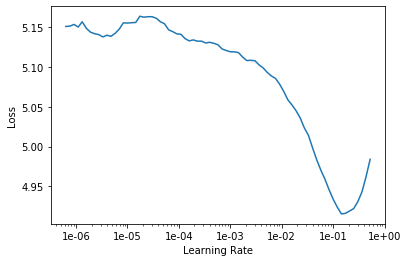

In [0]:
learn_1_lm.recorder.plot(suggestion=True)

In [0]:
lr = 5e-2

In [0]:
learn_1_lm.freeze()
learn_1_lm.fit_one_cycle(1, max_lr=lr,  moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.788533,4.291051,0.261723,73.043297,00:24


In [0]:
learn_1_lm.freeze_to(-2)
learn_1_lm.fit_one_cycle(1, max_lr=lr/2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.384405,4.235549,0.269692,69.099640,00:25


In [0]:
learn_1_lm.freeze_to(-3)
learn_1_lm.fit_one_cycle(1, max_lr=lr/2.6**4, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.724500,4.214493,0.270387,67.659874,00:28


In [0]:
learn_1_lm.save("stage-1-lm_1")

In [0]:
learn_1_lm.load("stage-1-lm_1");

In [0]:
learn_1_lm.unfreeze()

In [0]:
learn_1_lm.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.29E-06
Min loss divided by 10: 3.02E-04


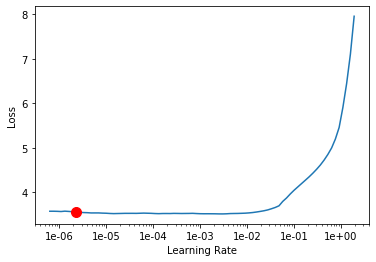

In [0]:
learn_1_lm.recorder.plot(suggestion=True)

In [0]:
learn_1_lm.fit_one_cycle(5, max_lr=slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.561946,4.220490,0.270486,68.066795,00:30
1,3.526309,4.214492,0.270486,67.659843,00:30
2,3.482746,4.212545,0.270767,67.528145,00:30
3,3.442975,4.210508,0.271114,67.390793,00:30
4,3.418633,4.210740,0.271280,67.406410,00:30


In [0]:
learn_1_lm.fit_one_cycle(5, max_lr=slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.408456,4.209607,0.270800,67.330048,00:30
1,3.404100,4.204316,0.271875,66.974808,00:30
2,3.362605,4.203504,0.272007,66.920387,00:30
3,3.321155,4.205853,0.271412,67.077820,00:30
4,3.294913,4.206696,0.271610,67.134331,00:30


In [0]:
learn_1_lm.save('complete_model_1')

Foram treinados oficialmente por apenas 10 épocas. Foram feitos diversos testes, mas com um número maior que esse já era possível se observar um processo de overfitting. Portanto, esse foi o número final escolhido.

Muitos parâmetros também foram testados, sendo os atuais os que apresentaram um melhor resultado. Mesmo que possua uma perplexidade alta, para a tarefa final de classificação, tal resultado já se mostrou suficiente.

In [0]:
learn_1_lm.load('complete_model_1');

Abaixo, apenas um teste para observar como o modelo se comporta. 

In [0]:
TEXT = "This is a movie about a which and a fairy who"
N_WORDS = 40
N_SENTENCES = 2

In [0]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

This is a movie about a which and a fairy who hit an ancient power of lust , lust , and lust , and all the power of power . The Countess Queen Elizabeth Elizabeth ( Elizabeth Elizabeth ) is a journalist and her
This is a movie about a which and a fairy who 's in love with a fairy tale through a parallel tale of love and love , in a world of love and love . The story focuses on the love of a straight man . xxbos Based on


In [0]:
learn_1_lm.save_encoder('fine_tuned_enc_1')

<h4> Parte 3: Classificador </h4>

Também utilizei o modelo <b>AWD LSTM</b> para o classificador, por ser aquele que apresenta os melhores resultados dentre os disponíveis na biblioteca. 

Nessa etapa, então, treino o modelo classificador final e o testo. Para isso, dividi os dados em 90% para treino e 10% para teste.

Repito o processo feito no treino do modelo de linguagem (selecionar os parâmetros do modelo, adequar os dados para o modelo, achar a melhor learning rate, etc).

In [0]:
from sklearn.model_selection import train_test_split

train_1, test_1 = train_test_split(df_1, test_size=0.1)

In [0]:
data_clas_1 = (TextList.from_df(train_1, vocab=data_lm.vocab, cols="overview")
             .split_by_rand_pct(0.2)
             .label_from_df(cols= 'genres' , classes=all_genres, label_delim=' ')
             .databunch(bs=bs))

In [0]:
data_clas_1.save('data_clas_1.pkl')

In [0]:
data_clas_1 = load_data('','data_clas_1.pkl', bs=bs)

In [0]:
data_clas_1.show_batch()

text,target
"xxbos gang - xxunk is a xxunk - witted man working at his father 's tiny xxunk bar near the han river . one day , gang - xxunk 's one and only daughter xxunk - xxunk comes back from school xxunk . she is angry at her uncle , xxunk - xxunk , who visited her school as her guardian xxunk drunk . ignoring her father 's xxunk for",Drama;Horror;Science
"xxbos jim morris never made it out of the minor leagues before a xxunk injury ended his xxunk career twelve years ago . now a married - with - children high - school chemistry teacher and baseball coach in texas , jim 's team makes a deal with him : if they win the district championship , jim will try out with a major - league organization . the bet",Drama;Family
"xxbos indian - born manmohan xxunk decided to re - locate to london , england , established himself , returned to india , got married to bebo , and after a period of 4 years got a xxunk for her so that she could live with him . shortly xxunk she gave birth to jasmeet . manmohan was always xxunk of bebo , as she was overly healthy and not",Drama;Romance
"xxbos in the 1970s the north american soccer league marked the first attempt to xxunk soccer to american sports fans . while most teams had only limited success at best , one managed to break through to genuine mainstream popularity - the new york cosmos . the xxunk of steve ross ( major executive at warner communications ) and the xxunk brothers ( xxunk of atlantic records ) , the",Documentary
"xxbos in 1950 , in south xxunk , xxunk - xxunk xxunk - xxunk lee and his xxunk - old old student brother , xxunk - xxunk lee , form a poor but happy family with their mother , xxunk - xxunk 's fiancé young - xxunk kim , and her young sisters . xxunk - xxunk and his mother are tough workers , who sacrifice themselves to send xxunk",Action;Adventure;Drama;History;War


In [0]:
learn_1_clas = None
gc.collect()

237

Para mensurar meu modelo, utilizei duas métricas diferentes. Uma sendo a <b>accuracy_thresh</b>, que mede acurácia de todas as palavras com a probabilidade a partir de um threshold, que foi estipulado como 2, e a outra sendo <b>fbeta</b>, sendo esse a média harmônica entre precision e recall, no caso com o peso maior para a métrica recall.


In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
fscore = partial(fbeta, thresh = 0.2, beta=2)
learn_1_clas = text_classifier_learner(data_clas_1, AWD_LSTM, drop_mult=0.5, metrics=[acc_02, fscore])

In [0]:
learn_1_clas.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (3436 items)
x: TextList
xxbos for some married couples , sex is an obsession that xxunk their belief in strict monogamy . the ability to act out their sexual fantasies is more important than xxunk any convention of love or marriage . sex with strangers xxunk an xxunk intimate portrait of three such couples , from the xxunk of fantasies xxunk to the xxunk of xxunk relationships , showing how their lives are profoundly affected by the lifestyle they lead . james and theresa , a couple in their xxunk , use their xxunk home as a pleasure palace travelling from club to club seducing couples xxunk they go . calvin and sarah are thinking about getting married when they meet julie , who does n't swing , and is n't bisexual - until she falls for calvin . xxunk almost xxunk sex for xxunk and gerard , who are passionate about xxunk , even as they question whether the lifestyle is really for them ...,xxbos britt reid ( seth xxunk ) , the heir t

In [0]:
learn_1_clas.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.92E-02
Min loss divided by 10: 1.32E-01


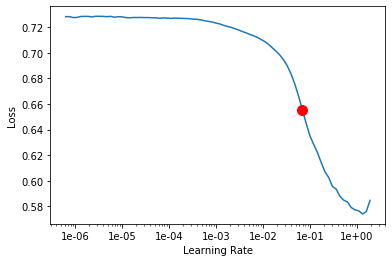

In [0]:
learn_1_clas.recorder.plot(suggestion=True)

In [0]:
lr = 5e-2

In [0]:
learn_1_clas.freeze()
learn_1_clas.fit_one_cycle(1, max_lr=lr,  moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.280473,0.219356,0.860140,0.636089,00:11


In [0]:
learn_1_clas.freeze_to(-2)
learn_1_clas.fit_one_cycle(1, max_lr=lr/2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.230580,0.215233,0.860343,0.650624,00:13


In [0]:
learn_1_clas.freeze_to(-3)
learn_1_clas.fit_one_cycle(1, max_lr=lr/2.6**4, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.211992,0.208582,0.868400,0.658159,00:23


In [0]:
learn_1_clas.save("stage-1-clas_1")

In [0]:
learn_1_clas.load("stage-1-clas_1");

In [0]:
learn_1_clas.unfreeze()

In [0]:
learn_1_clas.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


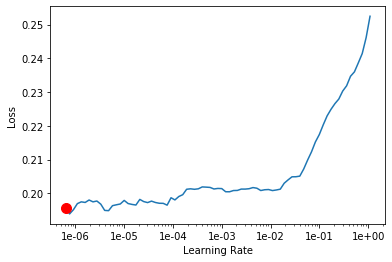

In [0]:
learn_1_clas.recorder.plot(suggestion=True)

In [0]:
learn_1_clas.fit_one_cycle(5, max_lr=slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.203953,0.207953,0.867133,0.660687,00:29
1,0.200996,0.205665,0.874075,0.665390,00:27
2,0.198263,0.204168,0.876913,0.666790,00:28
3,0.197237,0.204101,0.877876,0.664606,00:27
4,0.197801,0.207405,0.872150,0.659681,00:29


In [0]:
learn_1_clas.save("stage-2-clas_1")

In [0]:
learn_1_clas.load("stage-2-clas_1");

In [0]:
learn_1_clas.fit_one_cycle(5, max_lr=slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.199591,0.218692,0.866525,0.639902,00:30
1,0.196929,0.202332,0.878281,0.669781,00:31
2,0.196457,0.202206,0.877369,0.668394,00:30
3,0.194643,0.202807,0.877470,0.668454,00:30
4,0.191970,0.202256,0.879903,0.665955,00:28


In [0]:
learn_1_clas.save("stage-3-clas_1")

In [0]:
learn_1_clas.load("stage-3-clas_1");

In [0]:
learn_1_clas.fit_one_cycle(5, max_lr=slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.193358,0.204531,0.881676,0.672588,00:28
1,0.195362,0.203566,0.882031,0.675927,00:31
2,0.189448,0.203011,0.882994,0.674673,00:26
3,0.188816,0.203336,0.883653,0.673000,00:28
4,0.187865,0.203310,0.883703,0.672825,00:28


In [0]:
learn_1_clas.save("stage-4-clas_1")

In [0]:
learn_1_clas.load("stage-4-clas_1");

In [0]:
learn_1_clas.fit_one_cycle(5, max_lr=slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.189563,0.203738,0.882740,0.672745,00:31
1,0.186474,0.202727,0.883957,0.676702,00:26
2,0.187385,0.202332,0.884463,0.676347,00:31
3,0.181430,0.202183,0.882589,0.673361,00:26
4,0.181241,0.201954,0.884717,0.675137,00:28


In [0]:
learn_1_clas.save("stage-5-clas_1")

In [0]:
learn_1_clas.load("stage-5-clas_1");

In [0]:
learn_1_clas.fit_one_cycle(5, max_lr=slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.177137,0.198068,0.884109,0.666883,00:27
1,0.177747,0.197979,0.885426,0.665741,00:30
2,0.174043,0.197811,0.885933,0.668308,00:30
3,0.172770,0.197847,0.885071,0.667194,00:25
4,0.171996,0.198257,0.883298,0.665868,00:26


In [0]:
learn_1_clas.save("stage-6-clas_1")

In [0]:
learn_1_clas.load("stage-6-clas_1");

Foram treinadas em 25 épocas. Mais épocas foram testadas, mas acima desse número foi observado processo de overfitting. Outros parâmetros foram testados, mas dessa forma foi o que apresentou melhores métricas.

A seguir, iniciamos o processo de teste. A biblioteca não tem um método especíífico para testar, portanto, fiz um processo de validação com os dados que selecionei para teste. Para isso, criei uma base de dados contendo ambos dados de teste e treino e os diferenciei com uma coluna "is_valid". 

In [0]:
df_1_test_valid = test_1
df_1_train_valid = train_1

,genres,overview,title
1610,Action Thriller Adventure,a 16-year-old girl raised by her father to be ...,Hanna
3055,Comedy Drama Romance Science,"as an asteroid nears earth, a man finds himsel...",Seeking a Friend for the End of the World
3975,Comedy Drama,"damon runyon's fairytale, sweet and funny, is ...",Pocketful of Miracles
1101,Animation Action Comedy Family,"dex, a superdog sleuth, is the law of the land...",Foodfight!
3978,Thriller Mystery Drama Horror,the story of a man who wakes up in bed sufferi...,Amnesiac
...,...,...,...
1082,Action Adventure Crime Thriller,an aging cop is assigned the ordinary task of ...,16 Blocks
205,Adventure Action Crime Mystery,there is a new criminal mastermind at large (p...,Sherlock Holmes: A Game of Shadows
1756,Drama Comedy Romance,will freeman is a hip londoner who one day rea...,About a Boy
4306,Documentary,breast cancer has become the poster child of c...,"Pink Ribbons, Inc."


In [0]:
is_not_valid = len(df_1_train_valid) * [0]
df_1_train_valid['is_valid'] = is_not_valid
df_1_train_valid

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,genres,overview,title,is_valid
1981,Comedy Horror,each year the population of sleepy lake victor...,Piranha 3D,0
2493,Drama Romance,an innocent immigrant woman is tricked into a ...,The Immigrant,0
3225,Adventure Drama Thriller,unconventional narrative about the interaction...,Limbo,0
3428,Horror Thriller,genetically mutated bats escape and it's up to...,Bats,0
4749,Comedy Drama Romance,deals with the lives of the three irish cathol...,The Brothers McMullen,0
...,...,...,...,...
1318,Horror Mystery Science,scientists in the antarctic are confronted by ...,The Thing,0
2688,Thriller Mystery Adventure,"for their honeymoon, newlyweds cliff and cydne...",A Perfect Getaway,0
331,Adventure Fantasy,"john gregory, who is a seventh son of a sevent...",Seventh Son,0
2414,Comedy Romance,matt sullivan's last big relationship ended in...,40 Days and 40 Nights,0


In [0]:
is_valid = len(df_1_test_valid) * [1]
df_1_test_valid['is_valid'] = is_valid
df_1_test_valid

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,genres,overview,title,is_valid
1610,Action Thriller Adventure,a 16-year-old girl raised by her father to be ...,Hanna,1
3055,Comedy Drama Romance Science,"as an asteroid nears earth, a man finds himsel...",Seeking a Friend for the End of the World,1
3975,Comedy Drama,"damon runyon's fairytale, sweet and funny, is ...",Pocketful of Miracles,1
1101,Animation Action Comedy Family,"dex, a superdog sleuth, is the law of the land...",Foodfight!,1
3978,Thriller Mystery Drama Horror,the story of a man who wakes up in bed sufferi...,Amnesiac,1
...,...,...,...,...
1082,Action Adventure Crime Thriller,an aging cop is assigned the ordinary task of ...,16 Blocks,1
205,Adventure Action Crime Mystery,there is a new criminal mastermind at large (p...,Sherlock Holmes: A Game of Shadows,1
1756,Drama Comedy Romance,will freeman is a hip londoner who one day rea...,About a Boy,1
4306,Documentary,breast cancer has become the poster child of c...,"Pink Ribbons, Inc.",1


In [0]:
frames = [df_1_test_valid, df_train_valid]
test_1_df = pd.concat(frames)
test_1_df

,genres,overview,title,is_valid
1610,Action Thriller Adventure,a 16-year-old girl raised by her father to be ...,Hanna,1
3055,Comedy Drama Romance Science,"as an asteroid nears earth, a man finds himsel...",Seeking a Friend for the End of the World,1
3975,Comedy Drama,"damon runyon's fairytale, sweet and funny, is ...",Pocketful of Miracles,1
1101,Animation Action Comedy Family,"dex, a superdog sleuth, is the law of the land...",Foodfight!,1
3978,Thriller Mystery Drama Horror,the story of a man who wakes up in bed sufferi...,Amnesiac,1
...,...,...,...,...
1318,Horror Mystery Science,scientists in the antarctic are confronted by ...,The Thing,0
2688,Thriller Mystery Adventure,"for their honeymoon, newlyweds cliff and cydne...",A Perfect Getaway,0
331,Adventure Fantasy,"john gregory, who is a seventh son of a sevent...",Seventh Son,0
2414,Comedy Romance,matt sullivan's last big relationship ended in...,40 Days and 40 Nights,0


In [0]:
test_1_db = (TextList.from_df(test_1_df, vocab=data_lm.vocab, cols="overview")
             #grab all the text files in path
             .split_from_df(col='is_valid')
             .label_from_df(cols= 'genres' , classes=all_genres, label_delim=' ')
             #label them all with their folders
             .databunch(bs=bs))

In [0]:
test_1_db.show_batch()

text,target
"xxbos gang - du is a xxunk - witted man working at his father 's tiny snack bar near the han river . one day , gang - du 's one and only daughter hyun - seo comes back from school xxunk . she is angry at her uncle , nam - il , who visited her school as her guardian xxunk drunk . ignoring her father 's xxunk for",Drama;Horror;Science
"xxbos xxunk jackson ( cube ) is a bounty hunter with a lot of attitude and no interest in taking on a partner . working at xxunk bail bonds , jackson has unorthodox methods of tracking down low - life criminals , but they work , and one day he hopes to become his own boss and open up his own private investigation firm . xxunk wright ( xxunk )",Action;Adventure;Comedy
"xxbos an orphaned girl , driven by poverty at such a young age , makes a promise with an xxunk . in return for beauty and the xxunk of every man , she will never be with the man she loves . this spell can not be broken unless the impossible happens : snow falling in spring and the dead coming back to life . now a grown and beautiful",Action;Drama;Fantasy;Romance;Thriller
"xxbos indian - born manmohan xxunk decided to re - locate to london , england , established himself , returned to india , got married to bebo , and after a period of 4 years got a visa for her so that she could live with him . shortly xxunk she gave birth to jasmeet . manmohan was always xxunk of bebo , as she was overly healthy and not",Drama;Romance
"xxbos beautiful , sophisticated women are all over oscar xxunk . he is sensitive and compassionate , speaks french xxunk , is passionate about xxunk , and thinks the feature that tells the most about a woman is her hands . on the train home from xxunk academy for the thanksgiving weekend , oscar xxunk in his best friend that he has plans for this vacation -- he will win",Comedy;Drama;Romance


In [0]:
learn_1_clas.data = test_db

In [0]:
test_loss, acc_t, fbeta = learn_1_clas.validate(learn_1_clas.data.valid_dl)

Os resultados foram os seguintes:

In [0]:
test_loss

0.1995234

In [0]:
acc_t

tensor(0.8859)

In [0]:
fbeta

tensor(0.6765)

A partir dos resultados acima é possível observar que o teste seguiu a mesma distribuição da validação, possuindo valores muito próximos em acurácia e fbeta. 

<h4>Parte 4: Análise dos resultados</h4>

Inicio a análise plotando o gráfico de perdas em tempo de treino e validação:

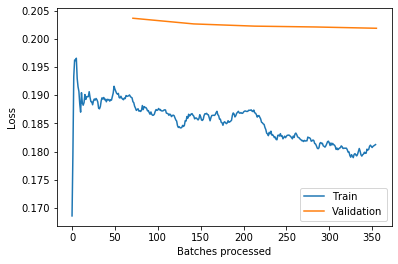

In [0]:
learn_1_clas.recorder.plot_losses()

A seguir, mostro algumas predições do modelo com descrições de filmes não contidas na base. As seguintes descrições são correspondentes aos filmes <b>Vingadores: o ultimato, Aladdin (live action), Frozen 2 e It 2</b> respectivamente. 

In [0]:
learn_1_clas.predict("After the devastating events of Avengers: Infinity War (2018), the universe is in ruins. With the help of remaining allies, the Avengers assemble once more in order to reverse Thanos' actions and restore balance to the universe. ", )

(MultiCategory Action;Adventure,
 tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.]),
 tensor([6.4343e-01, 7.2116e-01, 2.8022e-02, 6.3614e-09, 3.7355e-02, 1.6649e-03,
         3.3653e-03, 2.9995e-01, 4.5966e-02, 1.3323e-01, 5.5617e-09, 3.9447e-02,
         1.4979e-02, 8.2442e-04, 5.5968e-09, 7.2983e-03, 2.3160e-02, 2.4891e-01,
         5.4292e-09, 5.6870e-09, 9.8816e-02, 7.7677e-02, 2.8181e-03]))

Alvo correto: Ação, aventura

In [0]:
learn_1_clas.predict("A kind-hearted street urchin and a power-hungry Grand Vizier vie for a magic lamp that has the power to make their deepest wishes come true.")

(MultiCategory Comedy;Drama,
 tensor([0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.]),
 tensor([1.0517e-01, 4.8937e-02, 1.7347e-02, 1.4698e-07, 5.8766e-01, 1.0208e-01,
         8.2958e-03, 5.3740e-01, 6.5173e-02, 6.0267e-02, 1.5578e-07, 7.6069e-03,
         2.3782e-02, 2.3355e-02, 1.6312e-07, 3.1980e-02, 3.7536e-01, 5.9566e-02,
         1.5364e-07, 1.3954e-07, 1.5722e-01, 3.8361e-03, 4.4962e-03]))

Alvo correto: Comédia, drama, fantasia, aventura

In [0]:
learn_1_clas.predict("Anna, Elsa, Kristoff, Olaf and Sven leave Arendelle to travel to an ancient, autumn-bound forest of an enchanted land. They set out to find the origin of Elsa's powers in order to save their kingdom.")


(MultiCategory Adventure;Animation;Comedy;Family;Fantasy,
 tensor([0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.]),
 tensor([7.6299e-02, 9.6263e-01, 9.6206e-01, 1.3585e-08, 5.2786e-01, 7.4740e-05,
         6.7551e-05, 2.9589e-02, 9.9563e-01, 9.6443e-01, 1.3769e-08, 4.0750e-04,
         9.3134e-03, 4.3743e-03, 1.5102e-08, 2.8330e-04, 2.5651e-02, 5.7928e-03,
         1.4662e-08, 1.6850e-08, 1.1583e-03, 1.3461e-03, 2.2389e-02]))

Alvo correto: Animação, aventura, família, comédia

In [0]:
learn_1_clas.predict("Twenty-seven years after their first encounter with the terrifying Pennywise, the Losers Club have grown up and moved away, until a devastating phone call brings them back.")

(MultiCategory Horror,
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.]),
 tensor([2.2744e-02, 2.4621e-02, 5.6715e-03, 1.2096e-08, 2.6724e-01, 1.3844e-02,
         1.2570e-02, 1.2868e-01, 2.8143e-02, 4.5017e-02, 8.5566e-09, 2.3797e-04,
         8.6480e-01, 1.1834e-03, 8.7177e-09, 2.5588e-01, 1.8311e-02, 2.9534e-01,
         9.2819e-09, 1.0454e-08, 4.2449e-01, 1.0682e-04, 1.3238e-04]))

Alvo correto: Horror, thriller

Pode-se observar coerência do modelo a partir das predições acima. Não foi prevista nenhuma tag incorreta, e sim a ausência de algumas importantes.

Abaixo, mostro alguns resultados de validação.

In [0]:
learn_1_clas.show_results()

text,target,prediction
"xxbos xxunk jackson ( cube ) is a bounty hunter with a lot of attitude and no interest in taking on a partner . working at xxunk bail bonds , jackson has unorthodox methods of tracking down low - life criminals , but they work , and one day he hopes to become his own boss and open up his own private investigation firm . reggie wright ( epps )",Action;Adventure;Comedy,Action;Comedy;Crime;Thriller
"xxbos recess : school 's out is a 2001 animated film based on the disney television series recess . this film was produced by walt disney pictures and was released xxunk nationwide on xxunk 16 , xxunk the most exciting time of year at third street xxunk the end of the school year ! but boredom quickly sets in for protagonist xxunk xxunk , as his friends are headed for",Animation;Comedy;Family;Science,Comedy
"xxbos peter xxunk ( xxunk . , erin xxunk ) and karen allen ( the perfect storm ) star in this touching family drama about the xxunk power of basketball in a community torn apart by war . both a xxunk sports film and a tale of xxunk over xxunk , the basket is "" a xxunk dream movie with a whole lot of heart "" ( xxunk morning news",Drama,Comedy
"xxbos this is a story about the biggest financial fraud xxunk in hong kong , directed at the government of hong kong and involved all 7 million hong kong citizens ... no one is free from the scheme . within the four decades of xxunk hong kong 's financial xxunk , the xxunk has never come across an xxunk so huge and so well organized as in the xxunk xxunk",Crime;Thriller,Action;Comedy;Crime
"xxbos there 's more to ana xxunk than meets the eye . should she leave home , go to college and experience life ? or stay home , get married , and keep working in her sisters struggling xxunk factory ? it may seem like an east decision , but for 18 year - old ana , every choice she makes this summer will change her life . at home",Comedy;Drama,Comedy;Drama;Romance


A partir do trecho acima, pode-se observar um novo fenômeno: predição de algumas tags que não constam na realidade. Esse fenômeno pode ser melhor analisado no gráfico abaixo. 

In [0]:
import matplotlib.pyplot as plt

dict_genres = dict()
for i in all_genres:
	dict_genres[i] = 0

for i in df_1['genres']:
	genres = i.split()
	for genre in genres:
		dict_genres[genre] += 1

plt.bar(np.arange(len(all_genres)), dict_genres.values())
plt.xlabel('Genres')
plt.ylabel('Number of movies')
plt.xticks(np.arange(len(all_genres)), all_genres, rotation=45)
plt.show()

![alt text](https://drive.google.com/uc?id=1pJjefszqvfEtZvLUXhRum_rbyI6HoZoC)


Essa é a distribuição de gêneros de filmes na base de dados. Abaixo, temos a distribuição de gêneros preditos.

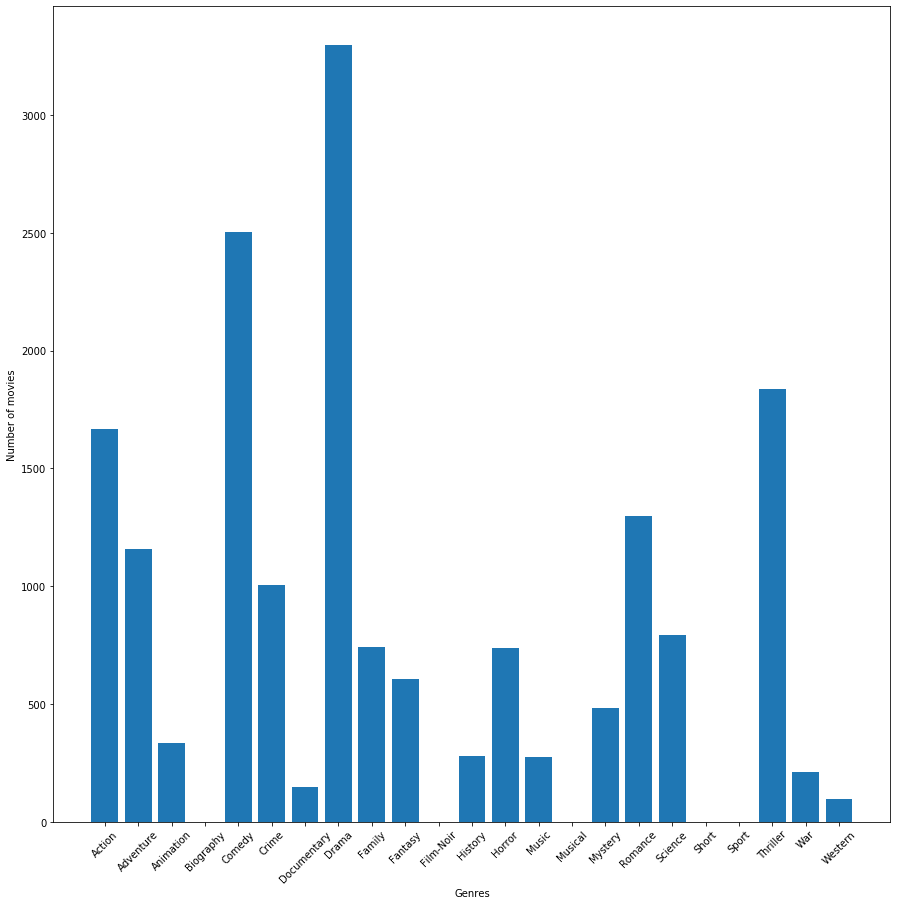

In [0]:
preds = learn_1_clas.get_preds(data_clas_1.valid_dl)
genres = []
for lista in preds[1]:
  count = 0
  film_genres = []
  for x in lista:
    if x == 1:
      film_genres.append(count)
    count +=1
  genres.append(film_genres) 

d = {i:0 for i in range(len(all_genres))}

for ls in genres:
  for elem in ls:
    d[elem] += 1

g = []
for i in range(len(all_genres)):
  g.append(d[i])


plt.bar(np.arange(len(all_genres)), kkk)
plt.xlabel('Genres')
plt.ylabel('Number of movies')
plt.xticks(np.arange(len(all_genres)), all_genres, rotation=45)
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

Comparando os gráficos, é possível observar que as tags estão numa distribuição semelhante. Entretanto, também observa-se que, no geral, quase todas as tags foram <b>mais preditas</b> do que, de fato, existem na original.

Uma possível maneira de se melhorar o modelo, seria aumentar o peso de <b>precision</b> no fbeta, uma vez que o modelo acabou prevendo mais tags erradas do que deixou de prever as certas.

Agora, vamos para a análise do modelo para a base de dados maior a comparação dos resultados de ambos. 

<h2>Modelo 2: Base de dados com ~40000 instâncias</h2>

<h4> Parte 1: Preprocessamento dos dados</h4>


O preprocessamento foi o mesmo da outra base de dados. Todo o processo foi feito a seguir. 

In [24]:
df_2 = pd.read_csv('/content/drive/My Drive/projetoNLP/movies_metadata.csv')
df_2

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,0.072051,/jldsYflnId4tTWPx8es3uzsB1I8.jpg,[],"[{'iso_3166_1': 'IR', 'name': 'Iran'}]",NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,/xZkmxsNmYXJbKVsTRLLx3pqGHx7.jpg,"[{'name': 'Sine Olivia', 'id': 19653}]","[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,/d5bX92nDsISNhu3ZT69uHwmfCGw.jpg,"[{'name': 'American World Pictures', 'id': 6165}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,Fa

In [26]:
df_2 = df_2.drop(columns=['adult', 'belongs_to_collection','homepage','original_title','imdb_id', 'id', 'budget', 'original_language', 'popularity', 'production_companies', 'production_countries', 'poster_path', 'release_date', 'revenue', 'release_date', 'revenue', 'video','runtime', 'spoken_languages', 'status', 'vote_average', 'vote_count','tagline'])
df_2

,genres,overview,title
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","Led by Woody, Andy's toys live happily in his ...",Toy Story
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",When siblings Judy and Peter discover an encha...,Jumanji
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",A family wedding reignites the ancient feud be...,Grumpier Old Men
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","Cheated on, mistreated and stepped on, the wom...",Waiting to Exhale
4,"[{'id': 35, 'name': 'Comedy'}]",Just when George Banks has recovered from his ...,Father of the Bride Part II
...,...,...,...
45461,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",Rising and falling between a man and woman.,Subdue
45462,"[{'id': 18, 'name': 'Drama'}]",An artist struggles to finish his work while a...,Century of Birthing
45463,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...","When one of her hits goes wrong, a professiona...",Betrayal
45464,[],"In a small town live two brothers, one a minis...",Satan Triumphant


In [27]:
df_2 = df_2[df_2['genres']!= '[]']
df_2 = df_2[df_2['overview'] != '']
df_2 = df_2[df_2['overview'] != None]
df_2 = df_2.dropna()
df_2 

,genres,overview,title
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","Led by Woody, Andy's toys live happily in his ...",Toy Story
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",When siblings Judy and Peter discover an encha...,Jumanji
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",A family wedding reignites the ancient feud be...,Grumpier Old Men
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","Cheated on, mistreated and stepped on, the wom...",Waiting to Exhale
4,"[{'id': 35, 'name': 'Comedy'}]",Just when George Banks has recovered from his ...,Father of the Bride Part II
...,...,...,...
45459,"[{'id': 878, 'name': 'Science Fiction'}]",It's the year 3000 AD. The world's most danger...,Caged Heat 3000
45460,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...","Yet another version of the classic epic, with ...",Robin Hood
45461,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",Rising and falling between a man and woman.,Subdue
45462,"[{'id': 18, 'name': 'Drama'}]",An artist struggles to finish his work while a...,Century of Birthing


In [29]:
def pre_proc(string):
    g = re.split("'|{|}|[|]|:| |,", string)
    new_genres = ''
    for x in g:
        if x in all_genres:
            new_genres += x + ' '
    return new_genres

df_2['genres'] = df_2['genres'].apply(pre_proc)
df_2['overview'] = df_2['overview'].str.lower()
df_2['overview'] = df_2['overview'].str.replace('([“”¨«»®´·º½¾¿¡§£₤‘’])', '')
df_2

,genres,overview,title
0,Animation Comedy Family,"led by woody, andy's toys live happily in his ...",Toy Story
1,Adventure Fantasy Family,when siblings judy and peter discover an encha...,Jumanji
2,Romance Comedy,a family wedding reignites the ancient feud be...,Grumpier Old Men
3,Comedy Drama Romance,"cheated on, mistreated and stepped on, the wom...",Waiting to Exhale
4,Comedy,just when george banks has recovered from his ...,Father of the Bride Part II
...,...,...,...
45459,Science,it's the year 3000 ad. the world's most danger...,Caged Heat 3000
45460,Drama Action Romance,"yet another version of the classic epic, with ...",Robin Hood
45461,Drama Family,rising and falling between a man and woman.,Subdue
45462,Drama,an artist struggles to finish his work while a...,Century of Birthing


<h4> Parte 2: Modelo de linguagem</h4>

O modelo de linguagem seguiu o mesmo da base de dados menor. O processo está todo listado a seguir.

In [30]:
data_2_lm = (TextList.from_df(df_2, cols='overview')
                .split_by_rand_pct(0.2) 
                .label_for_lm() 
                .databunch(bs = bs))
data_2_lm.show_batch() 

idx,text
0,"game that opens the door to a magical world , they unwittingly invite alan -- an adult who 's been trapped inside the game for 26 years -- into their living room . alan 's only hope for freedom is to finish the game , which proves risky as all three find themselves running from giant rhinoceroses , evil monkeys and other terrifying creatures . xxbos a family wedding reignites"
1,"a texas cattle rancher and his family and associates . xxbos after a four year absence , one time detective nick charles returns to new york with his new wife nora and their dog , xxunk . nick re - connects with many of his old cronies , several of whom are eccentric characters , to say the least . he 's also approached by dorothy xxunk whose inventor father"
2,"the hms bounty . however , bligh returns one year later , hell bent on avenging his captors . xxbos lavish biography of flo ziegfeld , the producer who became broadway 's biggest xxunk . xxbos alice , the only relatively normal member of the eccentric xxunk family , falls in love with tony kirby . his wealthy banker father , anthony p. kirby , and his snobbish mother ,"
3,". who will she choose ? does she go for true love or cheap sex ? she ca n't decide so she chooses both . but after managing to nurture a picture - perfect threesome , along comes ernest , a rich movie director with deep baby blues that sweep veronica off her feet . what 's a girl to do now ? xxbos look at the lives of struggling"
4,"is expecting her first baby and its father acts as if the responsibility is too much for him . xxbos xxunk with a velvet voice , 21-year - old violet xxunk heads to new york to pursue her dream of becoming a songwriter only to find her aspirations sidelined by the accolades and notoriety she receives at her "" day "" job as a barmaid at coyote ugly . the"


In [40]:
learn_2_lm = None
gc.collect()

7885

In [0]:
learn_2_lm = language_model_learner(data_2_lm,AWD_LSTM,pretrained_fnames=['/content/drive/My Drive/projetoNLP/models/lstm_fwd', '/content/drive/My Drive/projetoNLP/models/itos_wt103'],pretrained = False, drop_mult=0.5, metrics=[accuracy, perplexity], wd=0.2)

In [32]:
learn_2_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 8.32E-03


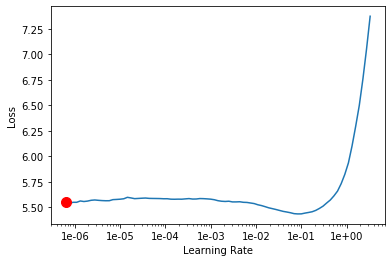

In [33]:
learn_2_lm.recorder.plot(suggestion=True)

In [42]:
lr = 5e-2
learn_2_lm.freeze()
learn_2_lm.fit_one_cycle(1, max_lr=lr,  moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.866873,4.605816,0.262573,100.064583,01:26


In [43]:
learn_2_lm.freeze_to(-2)
learn_2_lm.fit_one_cycle(1, max_lr=lr/2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.747992,4.534695,0.269616,93.194916,01:27


In [44]:
learn_2_lm.freeze_to(-3)
learn_2_lm.fit_one_cycle(1, max_lr=lr/2.6**4, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.405850,4.427064,0.279074,83.685349,01:35


In [0]:
learn_2_lm.save("stage-1-lm_2")

In [0]:
learn_2_lm.load("stage-1-lm_2");

In [0]:
learn_2_lm.unfreeze()

In [47]:
learn_2_lm.fit_one_cycle(5, max_lr=slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.293606,4.413839,0.279833,82.586052,01:41
1,4.263541,4.384590,0.281849,80.205154,01:40
2,4.228181,4.366146,0.282990,78.739555,01:40
3,4.179813,4.358043,0.283460,78.104073,01:41
4,4.154974,4.357157,0.283433,78.034988,01:40


In [0]:
learn_2_lm.save("stage-2-lm_2")

In [50]:
learn_2_lm.fit_one_cycle(5, max_lr=slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.163439,4.353565,0.283714,77.755150,01:41
1,4.157877,4.341101,0.284317,76.792122,01:41
2,4.142180,4.331927,0.285230,76.090759,01:40
3,4.098431,4.327503,0.285413,75.754974,01:40
4,4.070728,4.327183,0.285665,75.730667,01:40


In [0]:
learn_2_lm.save('stage-3-lm_2')

In [53]:
learn_2_lm.fit_one_cycle(5, max_lr=slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.087154,4.326065,0.285627,75.645966,01:41
1,4.113836,4.319843,0.285968,75.176773,01:40
2,4.070361,4.315159,0.286413,74.825539,01:40
3,4.049794,4.313502,0.286498,74.701515,01:40
4,4.002101,4.313478,0.286489,74.699989,01:40


In [0]:
learn_2_lm.save('stage-4-lm_2')

In [56]:
learn_2_lm.fit_one_cycle(5, max_lr=slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.020894,4.313473,0.286393,74.699310,01:41
1,4.049083,4.310872,0.286887,74.505402,01:41
2,4.021399,4.308359,0.287168,74.318375,01:41
3,3.975489,4.307435,0.287072,74.249832,01:40
4,3.958161,4.307865,0.286905,74.281845,01:41


In [0]:
learn_2_lm.save('stage-5-lm_2')

In [0]:
learn_2_lm.load("stage-5-lm_2");

In [59]:
learn_2_lm.fit_one_cycle(5, max_lr=slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.980094,4.309095,0.286649,74.373039,01:40
1,4.004145,4.307347,0.286879,74.243172,01:40
2,3.996051,4.306296,0.287037,74.165337,01:40
3,3.937715,4.306595,0.286961,74.187408,01:41
4,3.906505,4.307390,0.286861,74.246330,01:41


In [0]:
learn_2_lm.save_encoder('fine_tuned_enc_2')

In [0]:
TEXT = "This is a movie about a which and a fairy who"
N_WORDS = 40
N_SENTENCES = 2

In [62]:
print("\n".join(learn_2_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

This is a movie about a which and a fairy who knows what it is like to have a life of adventure . while trying to help out of his friends and step into the world , he meets and falls in love with a woman . she is just as
This is a movie about a which and a fairy who are all the greatest ghosts in the world . it is about that woman is on a train trip to a small town with the help of a mysterious woman . the story is about a gambler who is looking


Pode-se observar que o modelo de linguagem ficou <b>pior</b> que o anterior, utilizando-se os mesmos parâmetros, ao contrário do que eu esperava. Minha hipótese é que, por possuir mais dados, se tornou muito diferente do modelo original, além de possui mais sentenças em validação para evidenciar problemas no modelo.

Provavelmente, o ideal era alterar alguns parâmetros e, possivelmente, treinar por mais tempo. Entretanto, como o objetivo era comparar, mantive o modelo dessa mesma forma e decidi por prosseguir para a próxima etapa com esse modelo, visando observar, também, o impacto da diferença no classificador. 

<h4> Parte 3: Classificador</h4>

Assim como o modelo acima, segui o mesmo padrão do classificador da base de dados menor. A seguir temos o treino e o teste deste.

In [0]:
train_2, test_2 = train_test_split(df_2, test_size=0.1)

In [66]:
data_clas_2 = (TextList.from_df(train_2, vocab=data_2_lm.vocab, cols="overview")
             .split_by_rand_pct(0.2)
             .label_from_df(cols= 'genres' , classes=all_genres, label_delim=' ')
             .databunch(bs=bs))

In [79]:
learn_2_clas = None
gc.collect()

7726

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
fscore = partial(fbeta, thresh = 0.2, beta=2)
learn_2_clas = text_classifier_learner(data_clas_2, AWD_LSTM, drop_mult=0.5, metrics=[acc_02, fscore])

In [81]:
learn_2_clas.load_encoder('fine_tuned_enc_2')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (30471 items)
x: TextList
xxbos the old , weird america tracks the history of the anthology of american folk music from its initial compilation of 78 records from rural americana to its 1952 release on xxunk records , the urban folk revival of the 1960s , and its continuing influence on contemporary music .,xxbos a young widow discovers that her late husband has left her 10 messages intended to help ease her pain and start a new life .,xxbos harry and sue lewis met in the 40s as teenagers living in the bronx . he was an aspiring architect , she was the most beautiful girl in school , and both had a fondness for xxunk xxunk . they fell in love , got married , moved to los angeles , and had two kids . while struggling with his midlife crisis , harry receives an invitation for his high school 's reunion back so he takes sue and their teenage kids on a cross - country car trip back to the big apple . will they see in the bronx what they 

In [72]:
learn_2_clas.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.92E-02
Min loss divided by 10: 9.12E-02


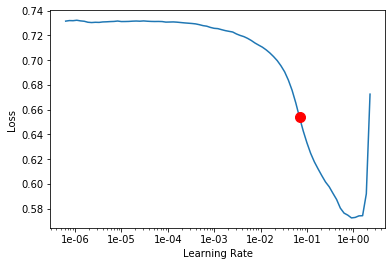

In [73]:
learn_2_clas.recorder.plot(suggestion=True)

In [0]:
lr = 1e-1

In [82]:
learn_2_clas.freeze()
learn_2_clas.fit_one_cycle(1, max_lr=lr,  moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.198154,0.174029,0.898265,0.666234,00:33


In [83]:
learn_2_clas.freeze_to(-2)
learn_2_clas.fit_one_cycle(1, max_lr=lr/2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.194937,0.171612,0.898094,0.673153,00:42


In [84]:
learn_2_clas.freeze_to(-3)
learn_2_clas.fit_one_cycle(1, max_lr=lr/2.6**4, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.182995,0.167112,0.902518,0.682513,01:00


In [0]:
learn_2_clas.save("stage-1-clas_2")

In [0]:
learn_2_clas.unfreeze()

In [87]:
learn_2_clas.fit_one_cycle(1, max_lr=slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.174216,0.165763,0.904270,0.685470,01:23


In [88]:
learn_2_clas.fit_one_cycle(5, max_lr=slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.170990,0.165206,0.904481,0.687248,01:12
1,0.171214,0.163745,0.903848,0.688958,01:12
2,0.166243,0.162927,0.906000,0.690728,01:17
3,0.164694,0.162687,0.906434,0.690560,01:11
4,0.167428,0.162343,0.906793,0.692019,01:18


In [0]:
learn_2_clas.save("stage-2-clas_2")

In [92]:
learn_2_clas.fit_one_cycle(1, max_lr=slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.161708,0.161292,0.906257,0.693511,01:26


In [0]:
learn_2_clas.save("stage-3-clas_2")

In [0]:
df_2_test_valid = test_2
df_2_train_valid = train_2

In [95]:
is_not_valid = len(df_2_train_valid) * [0]
df_2_train_valid['is_valid'] = is_not_valid
df_2_train_valid

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,genres,overview,title,is_valid
38416,Documentary Music,"the old, weird america tracks the history of t...","The Old, Weird America: Harry Smith's Antholog...",0
12298,Drama Romance,a young widow discovers that her late husband ...,P.S. I Love You,0
1381,Drama Romance,harry and sue lewis met in the 40s as teenager...,Falling in Love Again,0
39725,Action Drama,"when the closure of a railway is announced, em...",End of the Line,0
27653,Drama,"sometimes, we're just waiting for a miracle. a...",Miraculum,0
...,...,...,...,...
30576,Comedy Drama,"azulai is a policeman in jaffa, whose incompet...",The Policeman,0
23830,Romance Drama Music,all-stars from the previous step up installmen...,Step Up All In,0
8515,Drama,the life and career of vaudevillian and silent...,Man of a Thousand Faces,0
20009,Thriller Drama,life in a middle-class neighbourhood in presen...,Neighboring Sounds,0


In [96]:
is_valid = len(df_2_test_valid) * [1]
df_2_test_valid['is_valid'] = is_valid
df_2_test_valid

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,genres,overview,title,is_valid
17703,Documentary,from the team behind man on wire comes the sto...,Project Nim,1
30933,Comedy,"synder, the historian who has spent many years...",My Pet Monster,1
32325,Crime Adventure Comedy,davey haggart is quite certain of his paternit...,Sinful Davey,1
12451,Horror Action Science,a group of young film students run into real-l...,Diary of the Dead,1
32306,Fantasy Animation Drama,the story was liberally adapted from a short s...,Princess Iron Fan,1
...,...,...,...,...
29021,Action Thriller,iggy banks tells the story of two charming and...,Born Killers,1
30733,Comedy,ron simmons (josh cooke) is ready to settle do...,Bachelor Party 2: The Last Temptation,1
5595,Action Drama Romance Thriller,"a ruthless german spy, trying to get out of br...",Eye of the Needle,1
35444,Horror,a giant mutated alligator runs riot in a small...,Alligator 2 - The Mutation,1


In [97]:
frames = [df_2_test_valid, df_2_train_valid]
test_2_df = pd.concat(frames)
test_2_df

,genres,overview,title,is_valid
17703,Documentary,from the team behind man on wire comes the sto...,Project Nim,1
30933,Comedy,"synder, the historian who has spent many years...",My Pet Monster,1
32325,Crime Adventure Comedy,davey haggart is quite certain of his paternit...,Sinful Davey,1
12451,Horror Action Science,a group of young film students run into real-l...,Diary of the Dead,1
32306,Fantasy Animation Drama,the story was liberally adapted from a short s...,Princess Iron Fan,1
...,...,...,...,...
30576,Comedy Drama,"azulai is a policeman in jaffa, whose incompet...",The Policeman,0
23830,Romance Drama Music,all-stars from the previous step up installmen...,Step Up All In,0
8515,Drama,the life and career of vaudevillian and silent...,Man of a Thousand Faces,0
20009,Thriller Drama,life in a middle-class neighbourhood in presen...,Neighboring Sounds,0


In [98]:
test_2_db = (TextList.from_df(test_2_df, vocab=data_2_lm.vocab, cols="overview")
             .split_from_df(col='is_valid')
             .label_from_df(cols= 'genres' , classes=all_genres, label_delim=' ')
             .databunch(bs=bs))

test_2_db.show_batch()

text,target
"xxbos xxunk xxunk xxunk ( ( hindi : xxunk xxunk xxunk ) , english : wayward , crazy , insane ) is a 2002 bollywood action comedy directed by vikram bhatt . the film 's music was composed by anu malik , and the lyrics by sameer . reduced to a xxunk husband , his dream of making it big and being independent in the usa , dr . anmol",Action;Comedy
"xxbos big steve xxunk , gambler and proprietor of new york 's horseshoe cabaret , where his girl , bangles carson sings , is in desperate need of money . he arranges for his fellow bookies , especially sorrowful jones , to each pay him $ 1,000 for his racehorse , dream prince , to lose . with all bets being placed at the window , sorrowful encounters a gambler",Comedy;Drama;Family
"xxbos in this speculative one - man drama , we see former president richard xxunk nixon alone in his study , dictating his thoughts into a tape xxunk . his only company are a four - screen closed - circuit tv setup , the portraits on the walls , a bottle of xxunk regal - and a loaded pistol . at times addressing an imaginary judge in a court of",Drama
"xxbos dink purcell loves his alcoholic father , ex - heavyweight champion andy "" champ "" purcell , despite his frequent xxunk , his frequent gambling and their squalid living conditions . and there 's nothing andy would n't do for dink . when andy wins a race horse gambling , he gives it to dink and they race it at a tijuana track . there , dink meets linda",Drama
"xxbos guerilla filmmaker brendan xxunk unleashes i need that record ! the death ( or possible survival ) of the independent record store , "" an elegy for a vanishing subculture ... a lively , bittersweet film that examines - with caustic humor , brutal candor , and , ultimately , great affection - why roughly 3,000 indie record stores have closed across the nation over the past decade ,",Documentary


In [0]:
learn_2_clas.data = test_2_db

In [100]:
test_loss, acc_t, fbeta = learn_2_clas.validate(learn_2_clas.data.valid_dl)

In [101]:
test_loss

0.15682164

In [102]:
acc_t

tensor(0.9091)

In [103]:
fbeta

tensor(0.7073)

Pode-se aqui observar que os resultados foram, também, semelhantes aos de validação e com resultados ainda melhores que na base de dados menor, mesmo que com pouca diferença.

<h4> Parte 4: Análise dos resultados</h4>

Foi feita a mesma análise da base de dados anterior:

In [104]:
learn_2_clas.predict("After the devastating events of Avengers: Infinity War (2018), the universe is in ruins. With the help of remaining allies, the Avengers assemble once more in order to reverse Thanos' actions and restore balance to the universe. ", )

(MultiCategory ,
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([3.6801e-01, 4.3781e-01, 3.6616e-01, 7.7700e-06, 2.2141e-01, 2.5368e-02,
         4.4114e-02, 2.3905e-01, 1.9662e-01, 3.2143e-01, 6.2165e-06, 3.7650e-02,
         9.0262e-02, 1.6664e-02, 5.7243e-06, 4.8318e-02, 6.1175e-02, 4.0903e-01,
         6.8968e-06, 6.1664e-06, 1.2340e-01, 1.5426e-02, 9.9549e-03]))

In [105]:
learn_2_clas.predict("A kind-hearted street urchin and a power-hungry Grand Vizier vie for a magic lamp that has the power to make their deepest wishes come true.")

(MultiCategory Animation;Family,
 tensor([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.]),
 tensor([1.0163e-01, 3.1707e-01, 5.3685e-01, 1.2671e-07, 4.0599e-01, 6.3520e-03,
         1.5819e-02, 1.5164e-01, 5.3020e-01, 4.1267e-01, 9.8627e-08, 8.0238e-03,
         5.7853e-02, 2.8216e-02, 8.4948e-08, 2.0862e-02, 6.0820e-02, 1.2589e-01,
         9.7713e-08, 1.0870e-07, 2.6885e-02, 1.1768e-03, 2.8243e-03]))

In [106]:
learn_2_clas.predict("Anna, Elsa, Kristoff, Olaf and Sven leave Arendelle to travel to an ancient, autumn-bound forest of an enchanted land. They set out to find the origin of Elsa's powers in order to save their kingdom.")


(MultiCategory ,
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([1.3630e-01, 3.9092e-01, 4.7308e-01, 2.1711e-06, 2.7324e-01, 7.5795e-03,
         2.0938e-02, 2.3595e-01, 4.7060e-01, 4.7218e-01, 1.6194e-06, 2.0318e-02,
         8.8287e-02, 2.2683e-02, 1.4627e-06, 3.3561e-02, 7.9376e-02, 1.4620e-01,
         1.7762e-06, 1.6819e-06, 4.3160e-02, 3.7941e-03, 1.0540e-02]))

In [107]:
learn_2_clas.predict("Twenty-seven years after their first encounter with the terrifying Pennywise, the Losers Club have grown up and moved away, until a devastating phone call brings them back.")

(MultiCategory ,
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([8.9137e-02, 6.8877e-02, 7.5545e-02, 5.0045e-07, 2.1556e-01, 5.9393e-02,
         1.6840e-02, 3.7333e-01, 5.7633e-02, 1.7486e-01, 4.7205e-07, 9.0946e-03,
         3.3745e-01, 9.6477e-03, 4.3089e-07, 1.5112e-01, 8.5139e-02, 1.4179e-01,
         4.4991e-07, 4.3509e-07, 2.9460e-01, 2.4516e-03, 5.3204e-03]))

In [108]:
learn_2_clas.show_results()

text,target,prediction
"xxbos song for a xxunk boy is a 2003 film directed by xxunk walsh . it is based on the book of the same name by patrick galvin and is based on true events . the film is set in 1939 , on the brink of world war ii , in the st . xxunk reformatory school , a ruthless irish school for boys . gray , gloomy and ruled",Drama;Romance,Drama
"xxbos embezzler , xxunk , all around confidence man s. quentin quale is heading west to find his fortune ; he meets the crafty but simple brothers joseph and rusty xxunk in a train station , where they steal all his money . they 're heading west , too , because they 've heard you can just pick the gold off the ground . once there , they befriend an",Comedy;Western,Western
"xxbos every child who has lost a parent early in life ( whether due to death or the xxunk of divorce or for any other reason ) longs to see that parent again . many have kept up a running dialogue in their heads of things they would say to them if they ever see them again , and many of these things are bitter indeed . in this story",Drama,Drama
"xxbos the twin sisters helena and irene are born in helsinki during world war ii . a few months later their mother , xxunk , leaves the girls in the care of their grandmother , an old communist , and runs away with a german soldier . their life under the protection of their grandmother and the teachings of communism ends first with the death of stalin , then with",Drama,Drama
"xxbos the main character , nicknamed "" teddy bear "" by his friends and acquaintances , is a manager of a sports club in poland . one day he is detained at the border just as his sport team is off to a tournament . it appears that somebody has torn out a few pages from his passport . it occurs to him that perhaps his ex - wife has",Comedy,Comedy;Drama


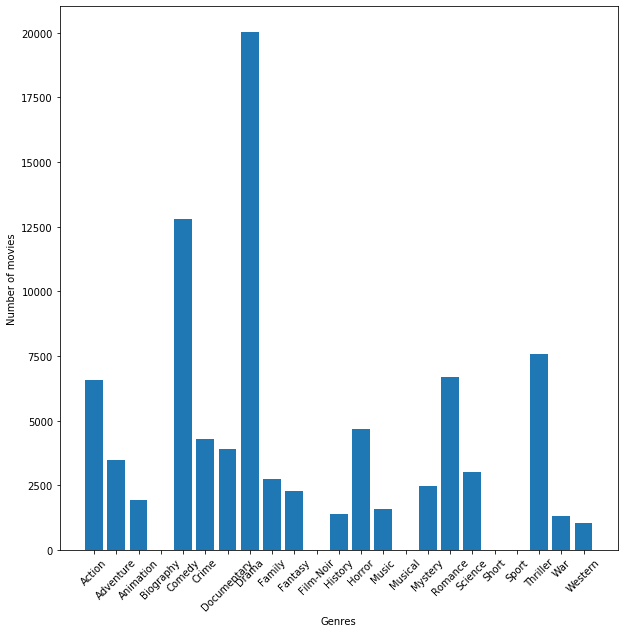

In [113]:
import matplotlib.pyplot as plt

dict_genres = dict()
for i in all_genres:
	dict_genres[i] = 0

for i in df_2['genres']:
	genres = i.split()
	for genre in genres:
		dict_genres[genre] += 1

plt.bar(np.arange(len(all_genres)), dict_genres.values())
plt.xlabel('Genres')
plt.ylabel('Number of movies')
plt.xticks(np.arange(len(all_genres)), all_genres, rotation=45)
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

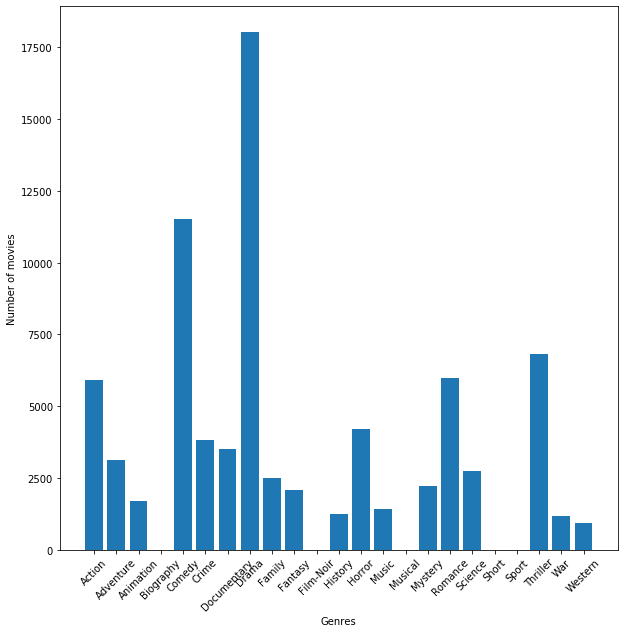

In [112]:
preds = learn_2_clas.get_preds(data_clas_2.valid_dl)
genres = []
for lista in preds[1]:
  count = 0
  film_genres = []
  for x in lista:
    if x == 1:
      film_genres.append(count)
    count +=1
  genres.append(film_genres) 

d = {i:0 for i in range(len(all_genres))}

for ls in genres:
  for elem in ls:
    d[elem] += 1

g = []
for i in range(len(all_genres)):
  g.append(d[i])


plt.bar(np.arange(len(all_genres)), g)
plt.xlabel('Genres')
plt.ylabel('Number of movies')
plt.xticks(np.arange(len(all_genres)), all_genres, rotation=45)
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

Nesse modelo, apesar dos melhores indicadores em tempo de teste e de validação, ocorreu o fenômeno oposto do anterior: as tags foram <b>menos preditas</b> do que de fato aparecem na base de dados oficial (ocorrendo, inclusive, de haver ausência de predições, como ocorreu em 3/4 testes de filmes que não constam na base). Como o problema é o oposto, uma possível solução seria a oposta: aumentar ainda mais o peso do recall. 

Entretanto, também observa-se uma mesma distribuição de dados da original, sendo um bom indicador do modelo.

Não consegui uma explicação exata de o porquê das diferenças observadas entre os modelos, uma vez que, observando a tabela de distribuição de tags, vemos que ambas as bases de dados possuem uma proporção muito semelhante. 

Algumas hipóteses:
1. Maior presença de dados pode apontar diferentes problemas não observados com poucos dados.
2. Diferença no modelo de linguagem.

<h2> Conclusão </h2>

Apesar de apresentarem falhas, ambos os modelos foram satisfatórios em sua tarefa de classificação, principalmente considerando que as descrições apresentadas são muito curtinhas e, muitas vezes, não possuem informações necessárias para prever todos os gêneros.